# Please run with T4 GPU if using Colab!

In [1]:
!git clone https://github.com/NimayRKumar/in_the_jungle.git

Cloning into 'in_the_jungle'...
remote: Enumerating objects: 970, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 970 (delta 40), reused 105 (delta 21), pack-reused 843
Receiving objects: 100% (970/970), 104.69 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (893/893), done.


In [2]:
%cd in_the_jungle/
!pip install -r requirements.txt

/content/in_the_jungle
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import shutil
import json
from ast import literal_eval
from audiomentations import AddGaussianNoise, AirAbsorption, ApplyImpulseResponse, BandPassFilter, GainTransition, RepeatPart, TimeStretch, TanhDistortion
from sklearn.model_selection import train_test_split
import time
import copy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preprocess Data & Create Datasets

In [5]:
def get_spectrogram(signal, sr=22050):
  spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr)
  return librosa.amplitude_to_db(spectrogram)

def get_mfcc(signal, n_mfcc=13):
    return librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc)

In [6]:
from preprocess import create_signal_dataframe, create_augmentations, add_gaussian_noise, add_air_absorption, add_band_pass_filter, gain_transition, tanh_distortion

In [7]:
aug_list = [add_gaussian_noise, add_air_absorption]

# Choose to either augment or not augment data by commenting out second line
# Only running on one dataset at a time due to memory limits
df = create_signal_dataframe()
df = create_augmentations(df.copy(), aug_list)

signal = np.vstack(df["signal"])
label = np.array(df["label"])
x_train, x_test, y_train, y_test = train_test_split(signal, label, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

spectrogram_train = get_spectrogram(x_train)
print(spectrogram_train.shape)

mfcc_train = get_mfcc(x_train)
print(mfcc_train.shape)

spectrogram_test = get_spectrogram(x_test)
print(spectrogram_test.shape)

mfcc_test = get_mfcc(x_test)
print(mfcc_test.shape)

(2100, 44100) (2100,) (525, 44100) (525,)
(2100, 128, 87)
(2100, 13, 87)
(525, 128, 87)
(525, 13, 87)


In [8]:
def create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35):
  train_data_spectrogram = []
  train_data_mfcc = []
  for i in range(spectrogram_train.shape[0]):
      train_data_spectrogram.append((spectrogram_train[i], y_train[i]))
      train_data_mfcc.append((mfcc_train[i], y_train[i]))
  train_loader_spectrogram = torch.utils.data.DataLoader(train_data_spectrogram, batch_size=batch_ize)
  train_loader_mfcc = torch.utils.data.DataLoader(train_data_mfcc, batch_size=batch_ize)
  return train_loader_spectrogram, train_loader_mfcc

In [9]:
train_loader_spectrogram, train_loader_mfcc = create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35)
test_loader_spectrogram, test_loader_mfcc = create_loader(spectrogram_test, mfcc_test, y_test, batch_ize=5)

### Image RNN

In [10]:
import torch
import torch.nn as nn

class ImageRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ImageRNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state with zeros
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

### Training Code

In [11]:
input_size = 87
hidden_size = 64
num_classes = 10
learning_rate = 0.005
num_epochs = 100

model_mfcc = ImageRNN(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_mfcc.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [12]:
def train(model, train_loader_mfcc, test_loader_mfcc, num_epochs, criterion, mfcc_model_save_path, learning_rate):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
    val_accu_lst = []
    train_per_weight_update = []
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader_mfcc):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_per_weight_update.append(loss)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        for i, (images, labels) in enumerate(test_loader_mfcc):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)


            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(
            "Epoch: [{}/{}], Validation Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, 100 * correct / total
            )
        )
        val_accu_lst.append(100 * correct / total)
        #torch.save(model.state_dict(), mfcc_model_save_path)
    return train_per_weight_update, val_accu_lst

In [13]:
spec_model_save_path = "./models/rnn_spectrogram.pth"
mfcc_model_save_path = "./models/rnn_mfcc.pth"

### Training RNN on MFCC Data

In [14]:
train_per_weight_update, val_accu_lst = train(
    model_mfcc,
    train_loader_mfcc,
    test_loader_mfcc,
    num_epochs,
    criterion,
    mfcc_model_save_path,
    learning_rate=learning_rate
)

Epoch: [1/100], Validation Accuracy: 29.3333
Epoch: [2/100], Validation Accuracy: 36.0000
Epoch: [3/100], Validation Accuracy: 42.0952
Epoch: [4/100], Validation Accuracy: 44.7619
Epoch: [5/100], Validation Accuracy: 48.5714
Epoch: [6/100], Validation Accuracy: 49.1429
Epoch: [7/100], Validation Accuracy: 50.4762
Epoch: [8/100], Validation Accuracy: 53.9048
Epoch: [9/100], Validation Accuracy: 56.5714
Epoch: [10/100], Validation Accuracy: 55.6190
Epoch: [11/100], Validation Accuracy: 59.6190
Epoch: [12/100], Validation Accuracy: 55.8095
Epoch: [13/100], Validation Accuracy: 58.8571
Epoch: [14/100], Validation Accuracy: 60.1905
Epoch: [15/100], Validation Accuracy: 62.6667
Epoch: [16/100], Validation Accuracy: 62.4762
Epoch: [17/100], Validation Accuracy: 62.4762
Epoch: [18/100], Validation Accuracy: 63.4286
Epoch: [19/100], Validation Accuracy: 60.5714
Epoch: [20/100], Validation Accuracy: 61.9048
Epoch: [21/100], Validation Accuracy: 64.5714
Epoch: [22/100], Validation Accuracy: 66.09

### Evaluating RNN on MFCC Data

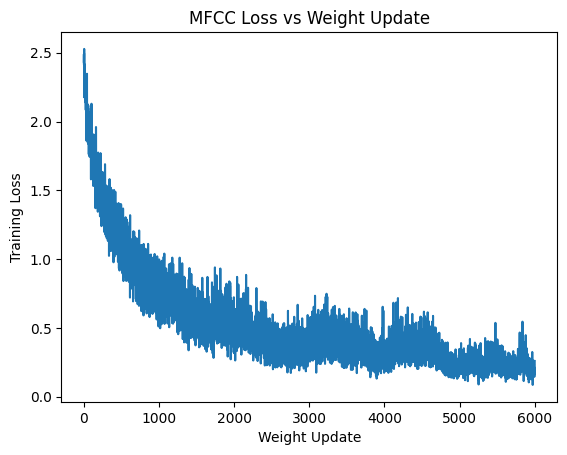

In [15]:
plt.plot([loss.item() for loss in train_per_weight_update])
plt.title("MFCC Loss vs Weight Update")
plt.xlabel("Weight Update")
plt.ylabel("Training Loss")
plt.show()

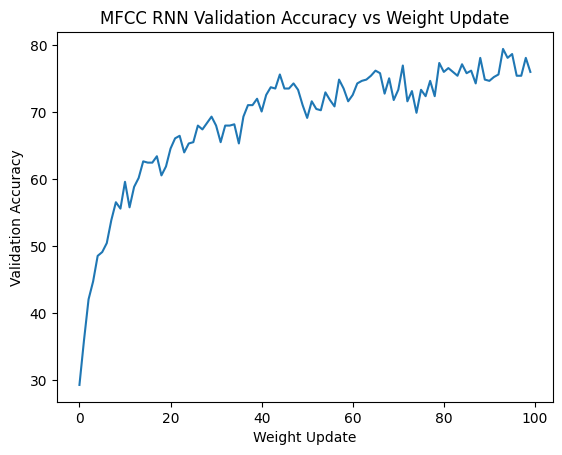

In [16]:
plt.plot(val_accu_lst)
plt.title("MFCC RNN Validation Accuracy vs Weight Update")
plt.xlabel("Weight Update")
plt.ylabel("Validation Accuracy")
plt.show()

### Training RNN on Spectrogram Data

In [17]:
input_size = 87
hidden_size = 64
num_classes = 10
learning_rate = 0.0005
num_epochs = 100

model_spec = ImageRNN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

In [18]:
train_per_weight_update_spec, val_accu_lst_spec = train(
    model_spec,
    train_loader_spectrogram,
    test_loader_spectrogram,
    num_epochs,
    criterion,
    spec_model_save_path,
    learning_rate=learning_rate
)

Epoch: [1/100], Validation Accuracy: 22.8571
Epoch: [2/100], Validation Accuracy: 22.8571
Epoch: [3/100], Validation Accuracy: 22.8571
Epoch: [4/100], Validation Accuracy: 22.8571
Epoch: [5/100], Validation Accuracy: 22.8571
Epoch: [6/100], Validation Accuracy: 22.8571
Epoch: [7/100], Validation Accuracy: 22.8571
Epoch: [8/100], Validation Accuracy: 22.8571
Epoch: [9/100], Validation Accuracy: 22.8571
Epoch: [10/100], Validation Accuracy: 22.8571
Epoch: [11/100], Validation Accuracy: 22.8571
Epoch: [12/100], Validation Accuracy: 22.8571
Epoch: [13/100], Validation Accuracy: 22.8571
Epoch: [14/100], Validation Accuracy: 22.8571
Epoch: [15/100], Validation Accuracy: 22.8571
Epoch: [16/100], Validation Accuracy: 22.8571
Epoch: [17/100], Validation Accuracy: 22.8571
Epoch: [18/100], Validation Accuracy: 22.8571
Epoch: [19/100], Validation Accuracy: 22.8571
Epoch: [20/100], Validation Accuracy: 22.8571
Epoch: [21/100], Validation Accuracy: 22.8571
Epoch: [22/100], Validation Accuracy: 22.85

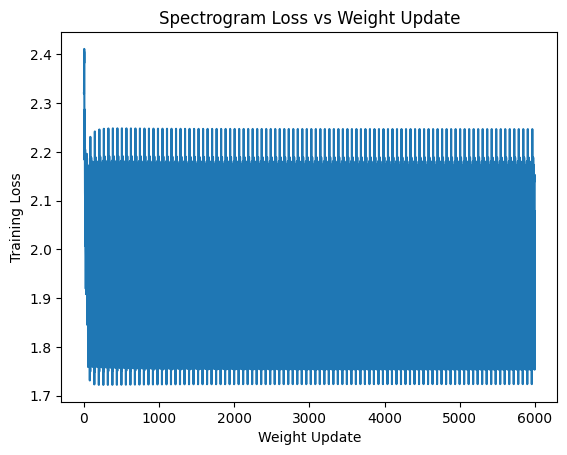

In [19]:
plt.plot([loss.item() for loss in train_per_weight_update_spec])
plt.title("Spectrogram Loss vs Weight Update")
plt.xlabel("Weight Update")
plt.ylabel("Training Loss")
plt.show()

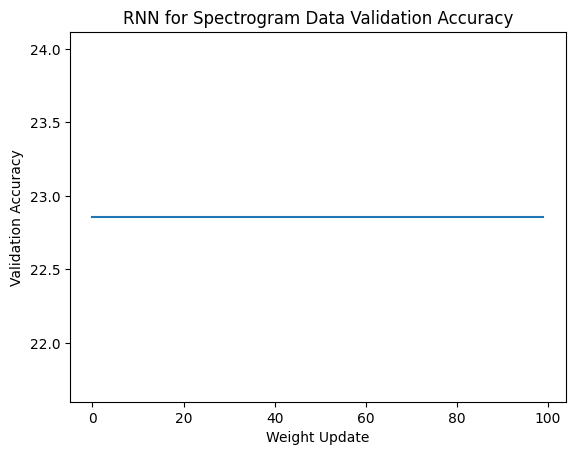

In [20]:
plt.plot(val_accu_lst_spec)
plt.title("RNN for Spectrogram Data Validation Accuracy")
plt.xlabel("Weight Update")
plt.ylabel("Validation Accuracy")
plt.show()